--- Step 1: Generating Chaotic Data ---

--- Step 2: Running Classical Baseline (AR Model) ---
Classical MSE: 0.00010

--- Step 3: Building Quantum Reservoir ---
Generating 110 quantum circuits...

--- Step 4: Running on Simulator (Ideal) ---
Simulator MSE: 0.07418

--- Step 5: Running on Real Hardware ---
Target Backend: ibm_fez
Transpiling circuits for hardware...
Submitting batch of 110 circuits... (Please wait)
Job ID: d5dtgv8nsj9s73basoq0
Hardware MSE: 0.10133

--- Step 6: Plotting Results ---


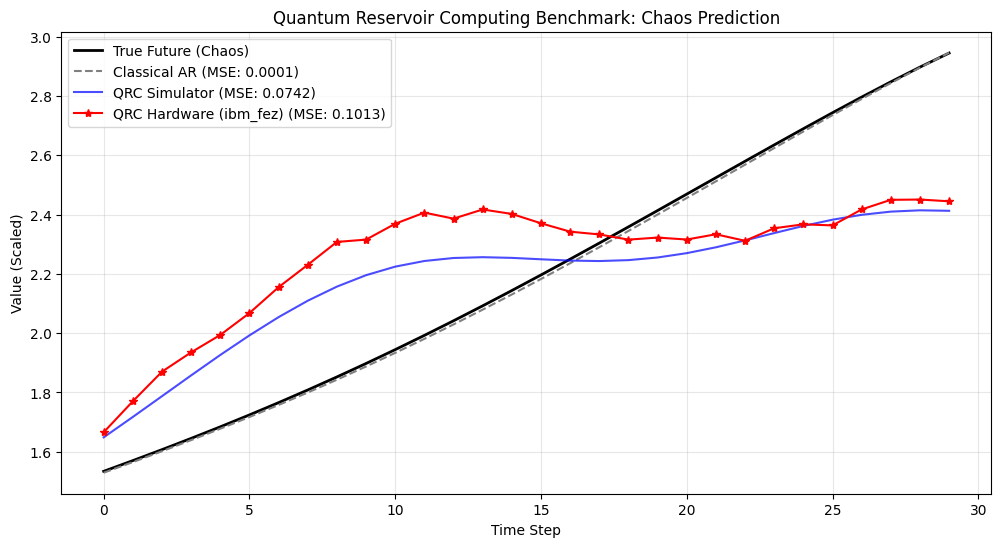

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as RuntimeEstimator

print("--- Step 1: Generating Chaotic Data ---")
def mackey_glass(length=1000, beta=0.2, gamma=0.1, n=10, tau=25):
    x = np.zeros(length + tau + 100)
    x[:tau] = 1.5 + np.random.random(tau) * 0.1
    for t in range(tau, len(x) - 1):
        x[t+1] = x[t] + beta * x[t-tau] / (1 + x[t-tau]**n) - gamma * x[t]
    return x[tau+100:]

# Generate and Scale
data_full = mackey_glass(length=200)
scaler = MinMaxScaler(feature_range=(0, np.pi))
data_scaled = scaler.fit_transform(data_full.reshape(-1, 1)).flatten()

# Train/Test Split
# Here we use 'past' values to predict 'future'
train_len = 80
test_len = 30 # Keep small for hardware speed
total_len = train_len + test_len

X_data = data_scaled[:total_len]        # Input (Time t)
y_data = data_scaled[1:total_len+1]     # Target (Time t+1)

X_train, X_test = X_data[:train_len], X_data[train_len:]
y_train, y_test = y_data[:train_len], y_data[train_len:]

print("\n--- Step 2: Running Classical Baseline (AR Model) ---")
# Simple Ridge Regression on the raw data (Linear prediction)
classical_model = Ridge(alpha=0.1)
classical_model.fit(X_train.reshape(-1, 1), y_train)
y_pred_classical = classical_model.predict(X_test.reshape(-1, 1))
mse_classical = mean_squared_error(y_test, y_pred_classical)
print(f"Classical MSE: {mse_classical:.5f}")

print("\n--- Step 3: Building Quantum Reservoir ---")
num_qubits = 5
reservoir_depth = 2

def create_reservoir_circuit(input_value):
    qc = QuantumCircuit(num_qubits)
    # Encoding (Injecting the Data)
    for i in range(num_qubits):
        qc.ry(input_value, i)
        qc.rz(input_value * 2, i)

    # Reservoir (Scramble Data)
    # use fixed random parameters to create complexity
    res = EfficientSU2(num_qubits, entanglement='linear', reps=reservoir_depth)
    np.random.seed(42) # Fix seed for reproducibility
    num_params = res.num_parameters
    random_weights = np.random.uniform(0, 2*np.pi, num_params)
    res = res.assign_parameters(random_weights)

    qc.compose(res, inplace=True)
    return qc

# Pre-generate ALL circuits (Train + Test)
print(f"Generating {total_len} quantum circuits...")
circuits_all = [create_reservoir_circuit(x) for x in X_data]

# Define Observables (Features we extract)
observables = [SparsePauliOp(f"I"*i + "Z" + "I"*(num_qubits-1-i)) for i in range(num_qubits)]

print("\n--- Step 4: Running on Simulator (Ideal) ---")
sim_estimator = StatevectorEstimator()

# Create PUBs for local estimator
pubs_sim = [(qc, observables) for qc in circuits_all]

job_sim = sim_estimator.run(pubs_sim)
results_sim = job_sim.result()

# Extract Features
features_sim = np.array([res.data.evs for res in results_sim])
X_train_sim, X_test_sim = features_sim[:train_len], features_sim[train_len:]

# Train Readout Layer
model_sim = Ridge(alpha=0.1)
model_sim.fit(X_train_sim, y_train)
y_pred_sim = model_sim.predict(X_test_sim)
mse_sim = mean_squared_error(y_test, y_pred_sim)
print(f"Simulator MSE: {mse_sim:.5f}")

print("\n--- Step 5: Running on Real Hardware ---")

# paste your API and CRN below

token = "TOKEN"
instance = "CRN"

QiskitRuntimeService.save_account(
    token=token,
    channel="ibm_cloud",
    instance=instance,
    name="NAME",
    overwrite=True
)
service = QiskitRuntimeService(name="NAME")
backend = service.least_busy(operational=True, simulator=False)
print(f"Target Backend: {backend.name}")

# Transpile Batch
print("Transpiling circuits for hardware...")
isa_circuits = transpile(circuits_all, backend=backend, optimization_level=1)
isa_observables = [op.apply_layout(isa_circuits[0].layout) for op in observables]

# Prepare Payload
pubs_hw = [(qc, isa_observables) for qc in isa_circuits]

try:
    print(f"Submitting batch of {len(pubs_hw)} circuits... (Please wait)")
    hw_estimator = RuntimeEstimator(mode=backend)
    job_hw = hw_estimator.run(pubs_hw)
    print(f"Job ID: {job_hw.job_id()}")

    # Wait for results
    results_hw = job_hw.result()

    # Extract Features
    features_hw = np.array([res.data.evs for res in results_hw])
    X_train_hw, X_test_hw = features_hw[:train_len], features_hw[train_len:]

    # Train Readout Layer (Train on Hardware features!)
    model_hw = Ridge(alpha=0.1)
    model_hw.fit(X_train_hw, y_train)
    y_pred_hw = model_hw.predict(X_test_hw)
    mse_hw = mean_squared_error(y_test, y_pred_hw)
    print(f"Hardware MSE: {mse_hw:.5f}")

except Exception as e:
    print(f"Hardware Run Failed: {e}")
    y_pred_hw = None
    mse_hw = 0


print("\n--- Step 6: Plotting Results ---")
plt.figure(figsize=(12, 6))

# Plot True Data
plt.plot(range(test_len), y_test, label="True Future (Chaos)", color='black', linewidth=2)

# Plot Classical
plt.plot(range(test_len), y_pred_classical, label=f"Classical AR (MSE: {mse_classical:.4f})", color='gray', linestyle='--')

# Plot Simulator
plt.plot(range(test_len), y_pred_sim, label=f"QRC Simulator (MSE: {mse_sim:.4f})", color='blue', alpha=0.7)

# Plot Hardware
if y_pred_hw is not None:
    plt.plot(range(test_len), y_pred_hw, label=f"QRC Hardware ({backend.name}) (MSE: {mse_hw:.4f})", color='red', marker='*', linestyle='-')

plt.title(f"Quantum Reservoir Computing Benchmark: Chaos Prediction")
plt.xlabel("Time Step")
plt.ylabel("Value (Scaled)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()